In [2]:
%load_ext autoreload
%autoreload 2
from HDMSpectra import HDMSpectra
import numpy as np
import matplotlib.pyplot as plt

In [3]:
HDM_Channel2Num = {
    "bbar": 5,
    "ttbar": 6,
    "ee": 11,
    "uu": 13,
    "tt": 15,
    "WW": 24,
    "ZZ": 23,
    "gamma": 22,
    "nue": 12,
    "numu": 14,
    "nutau": 16,
}
def center_pt(E):
    return (E[1:]+E[:-1])/2.

# Request 1

In [3]:
flx = {}
obs_E = 1e5 #(PeV)
c = "ttbar"
for i, obs_E in enumerate([3e5, 5e5, 1e6]):
    flx[i] = []
    for M in np.logspace(4.5, 12, 50):
        finalstate = 22   # photon
        initialstate = HDM_Channel2Num[c]
        x = np.logspace(-6.,0.,25000)
        
        temp = HDMSpectra.spec(finalstate, initialstate, x, M,
                                      data = "../DarkMatter/external/HDMSpectra/data/HDMSpectra.hdf5", 
                                      annihilation=True)
        E = x*M
        E = center_pt(E)
        
        total = sum(center_pt(temp)*np.diff(x)*E)
        observable = (E<obs_E)

        vts = sum((center_pt(temp)*np.diff(x)*E)[observable])


        flx[i].append([M, total, vts])
    flx[i] = np.asarray(flx[i])    

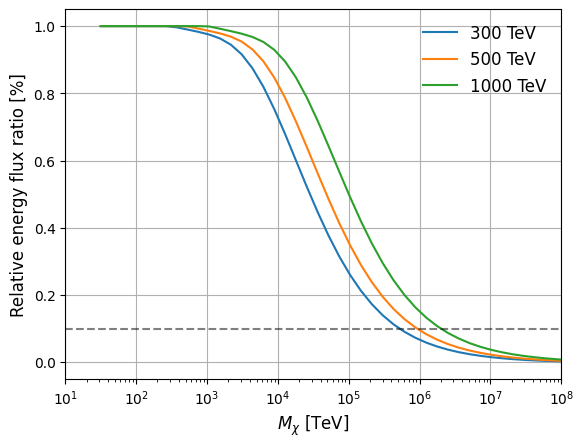

In [4]:
for c, cl in enumerate(["300 TeV", "500 TeV", "1000 TeV"]):
    plt.plot(flx[c][:,0]/1000., flx[c][:,2]/flx[c][:,1], label=cl)
    data = np.asarray([flx[c][:,0]/1000., flx[c][:,2]/flx[c][:,1]]).T
plt.xscale("log")
plt.axhline(0.1, color="k", ls="--", alpha=0.5)
plt.grid()
plt.legend(ncol=1, fontsize=12, frameon=False)
plt.xlabel("$M_{\chi}$ [TeV]", fontsize=12)
plt.ylabel("Relative energy flux ratio [%]", fontsize=12)
plt.ylim(-0.05,)
plt.xlim(1e1, 1e8)

# Request 2

In [5]:
def plotExpULcurve(filename=None, dwarf=None, package=None, channel = None, 
    ax=None, addTheta=False, version="all", mean_only=False, add_mean=False, 
    units="GeV", which=[68, 95], export=False, addRelic=False, **kwargs):
    
    uls = np.load(filename, allow_pickle=True).item()

    mass = list(uls.keys())
    mass.sort()
    mean_val = []
    error_cont = []

    for m in mass:
        if len(uls[m]) == 0:
            mean_val.append(np.nan)
            error_cont.append([np.nan, np.nan, np.nan, np.nan])
        else:
            mean_val.append(10**np.percentile(uls[m], 50))
            error_cont.append([10**np.percentile(uls[m], 16), 10**np.percentile(uls[m], 84), 10**np.percentile(uls[m], 2.5), 10**np.percentile(uls[m], 97.5)])
    
    mass=np.asarray(mass)
    if units == "TeV":
        mass = mass/1e3
    mean_val = np.asarray(mean_val)
    error_cont = np.asarray(error_cont)

    if ax == None:
        ax = plt.gca()

    etc = None
    
    if mean_only:
        ax.plot(mass, mean_val, label=kwargs.pop("label",None), **kwargs)

        if export:
            data = np.asarray([mass, mean_val]).T
            np.save(filename.split(".")[0]+"_plot", data)
    else:
        if add_mean:
            etc = ax.plot(mass, mean_val, label=kwargs.pop("label",None), color=kwargs.pop("color",None))

        if 95 in which:
            if etc is not None:
                c = etc[0].get_color()
            else:
                c = kwargs.pop("color",None)
            etc = ax.plot(mass, error_cont[:,2], alpha=0.5, ls="--", color = c)    
            ax.plot(mass, error_cont[:,3], alpha=0.5, ls="--", color = etc[0].get_color())

        if 68 in which:
            if 95 in which:
                ax.fill_between(mass, error_cont[:,0], error_cont[:,1], color = etc[0].get_color(), alpha=0.2, label=kwargs.pop("label",None))
            else:
                ax.fill_between(mass, error_cont[:,0], error_cont[:,1], alpha=0.2, label=kwargs.pop("label",None))

        if export:
            data = np.asarray([mass, mean_val, error_cont[:,0], error_cont[:,1], error_cont[:,2], error_cont[:,3]]).T
            np.save(filename.split(".")[0]+"_plot", data)

    ax.set_xscale("log")
    ax.set_yscale("log")
    if units == "GeV":
        ax.set_xlabel(r"$M_{\chi}$ [GeV]", fontsize=15)
    elif units == "TeV":
        ax.set_xlabel(r"$M_{\chi}$ [TeV]", fontsize=15)

    if addRelic:
        ax.axhline(2.4e-26, ls="-.", color="r", label="Thermal relic")
        ymin = 5e-27

    ax.set_ylabel(r"$\langle \sigma v \rangle$ [cm$^{3}$/s]", fontsize=15)
    ax.grid(b=True, which="major")
    ax.grid(b=True, which="minor", ls=":", lw=0.5)
    ax.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

def plotUnitarity(composite=[1e-1, 1e-2, 1e-3]):
    vrel = 2.e-5
    TeV2cm3s = 1.1673299710900705e-23

    def slim(m):
        "m [TeV]"
        return TeV2cm3s*(4.*np.pi)/(m**2.*vrel)

    def Rlim(m, Rinv):
        "m [TeV], Rinv [TeV]"
        R = 1./Rinv
        return TeV2cm3s*(4.*np.pi)/(m**2.*vrel)*(1.+m*vrel*R)**2.

    ax = plt.gca()

    ax.set_xlabel(r'$M_{\chi}$ [TeV]',fontsize=15)
    ax.set_ylabel(r'$\langle \sigma v \rangle$ [cm$^3$/s]',fontsize=15)

    ax.axvline(194.,ls="-",c='k',lw=0.8)
    ax.fill_between([10,194],[1.e-28,1.e-28],[1.e-16,1.e-16],color=(0.8,0.8,0.8),alpha=0.3)

    ax.plot([10.,194],[2.4e-26,2.4e-26],c='red',lw=1.5)

    mv=np.logspace(1.,np.log10(4.e4),100)
    cv="k"

    if len(composite)>=1:
        ax.text(3e4,4e-18,r'Composite Unitarity',fontsize=13,color="k", ha="right")

    for com in composite:
        ax.plot(mv,Rlim(mv,com),ls=(0, (3, 1, 1, 1, 1, 1)),c=cv,lw=0.8,zorder=2)
        if com == 1e-1:
            ax.text(3.5e4,8e-25,r'$R=(100~{\rm GeV})^{-1}$',fontsize=11,color="k", ha="right")
        elif com == 1e-2:
            ax.text(3.5e4,5e-23,r'$R=(10~{\rm GeV})^{-1}$',fontsize=11,color="k", ha="right")
        elif com == 1e-3:
            ax.text(3.5e4,5e-21,r'$R=(1~{\rm GeV})^{-1}$',fontsize=11,color="k", ha="right")
    
    ax.plot([10.,4.e4],[slim(10.),slim(4.e4)],c=cv,lw=1.5,zorder=2)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.text(70,6.e-27,r'Thermal',fontsize=13, ha="center")
    ax.text(70,2.e-27,r'$\langle \sigma v \rangle$',fontsize=13, ha="center")
     
    ax.text(1.1e4, 2e-26,r'Partial-Wave Unitarity',fontsize=13,color='k',rotation=339, ha="right")
    
    ax.set_xlim(25, 4e4)
    ax.set_ylim(1e-28, 1e-16)

/var/folders/l7/lw8bbmf92bqcgcyn64b6n0qm0000gn/T/ipykernel_28768/3607811604.py:71: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which="major")
/var/folders/l7/lw8bbmf92bqcgcyn64b6n0qm0000gn/T/ipykernel_28768/3607811604.py:72: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which="minor", ls=":", lw=0.5)


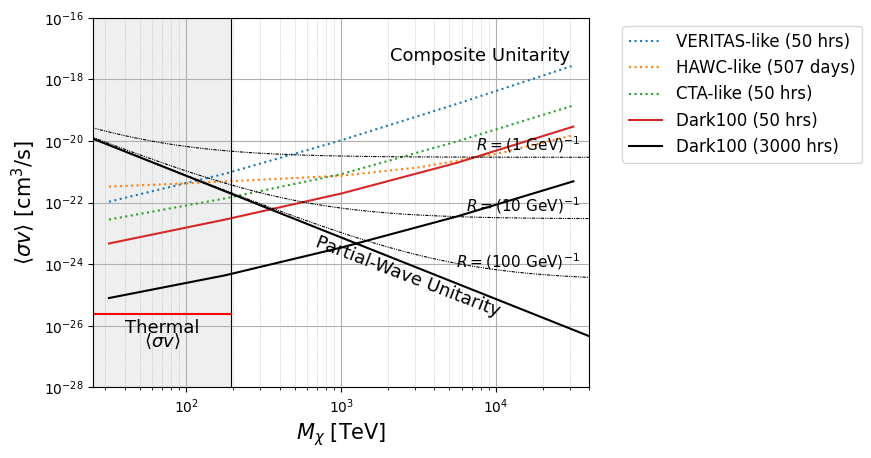

In [10]:
plotExpULcurve(filename="./data/vts_like_ttbar_50h.npy", units="TeV", label="VERITAS-like (50 hrs)", ls = ":", mean_only=True)
plotExpULcurve(filename="./data/hawc_like_ttbar_507d.npy", label="HAWC-like (507 days)", units="TeV", ls = ":", mean_only=True)
plotExpULcurve(filename="./data/cta_like_ttbar_50h.npy", label=r"CTA-like (50 hrs)", units="TeV", ls = ":", mean_only=True)
plotExpULcurve(filename="./data/proposal_EA10_50h_ttbar.npy", units="TeV", label="Dark100 (50 hrs)", mean_only=True)
plotExpULcurve(filename="./data/proposal_EA10_3000h_ttbar.npy", units="TeV", label="Dark100 (3000 hrs)", color="k", mean_only=True)

plotUnitarity()
